# **Modelo de Previs√£o de Pre√ßos de Im√≥veis em S√£o Paulo**

Importa√ß√£o das principais bibliotecas e da base de dados

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("argonalyst/sao-paulo-real-estate-sale-rent-april-2019")

print("Path to dataset files:", path)

In [195]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import geopandas as gpd
import contextily as ctx

### 1 - An√°lise Explorat√≥ria da Base de Dados e Tratamento de Dados

In [196]:
# Caminho do arquivo com barras duplas (ou use raw string com prefixo 'r')
caminho_csv = r'C:\Users\luuka\.cache\kagglehub\datasets\argonalyst\sao-paulo-real-estate-sale-rent-april-2019\versions\1\sao-paulo-properties-april-2019.csv'

# Lendo o arquivo
df = pd.read_csv(caminho_csv)

In [197]:
df.head()

Price  Condo  Size  Rooms  Toilets  Suites  Parking  Elevator  Furnished  \
0    930    220    47      2        2       1        1         0          0   
1   1000    148    45      2        2       1        1         0          0   
2   1000    100    48      2        2       1        1         0          0   
3   1000    200    48      2        2       1        1         0          0   
4   1300    410    55      2        2       1        1         1          0   

   Swimming Pool  New               District Negotiation Type Property Type  \
0              0    0  Artur Alvim/S√£o Paulo             rent     apartment   
1              0    0  Artur Alvim/S√£o Paulo             rent     apartment   
2              0    0  Artur Alvim/S√£o Paulo             rent     apartment   
3              0    0  Artur Alvim/S√£o Paulo             rent     apartment   
4              0    0  Artur Alvim/S√£o Paulo             rent     apartment   

    Latitude  Longitude  
0 -23.543138 -46.479486  
1 -23.550239 -46.480718  
2 -23.542818 -46.485665  
3 -23.547171 -46.483014  
4 -23.525025 -46.482436

In [198]:
# Visualiza√ß√£o da distribui√ß√£o por apartamentos por quartos
px.scatter(df, x='Rooms', y='Price')

In [199]:
df['Negotiation Type'].unique()

array(['rent', 'sale'], dtype=object)

In [200]:
df['District'].unique()

array(['Artur Alvim/S√£o Paulo', 'Bel√©m/S√£o Paulo', 'Canga√≠ba/S√£o Paulo',
       'Carr√£o/S√£o Paulo', 'Cidade L√≠der/S√£o Paulo',
       'Cidade Tiradentes/S√£o Paulo', 'Ermelino Matarazzo/S√£o Paulo',
       'Iguatemi/S√£o Paulo', 'Itaim Paulista/S√£o Paulo',
       'Itaquera/S√£o Paulo', 'Jardim Helena/S√£o Paulo',
       'Jos√© Bonif√°cio/S√£o Paulo', 'Lajeado/S√£o Paulo',
       'Parque do Carmo/S√£o Paulo', 'Penha/S√£o Paulo',
       'Ponte Rasa/S√£o Paulo', 'Sapopemba/S√£o Paulo',
       'S√£o Lucas/S√£o Paulo', 'S√£o Mateus/S√£o Paulo',
       'S√£o Miguel/S√£o Paulo', 'S√£o Rafael/S√£o Paulo',
       'Tatuap√©/S√£o Paulo', 'Vila Curu√ß√°/S√£o Paulo',
       'Vila Formosa/S√£o Paulo', 'Vila Jacu√≠/S√£o Paulo',
       'Vila Matilde/S√£o Paulo', 'Vila Prudente/S√£o Paulo',
       'Cambuci/S√£o Paulo', 'Campo Belo/S√£o Paulo',
       'Campo Grande/S√£o Paulo', 'Campo Limpo/S√£o Paulo',
       'Cap√£o Redondo/S√£o Paulo', 'Cidade Ademar/S√£o Paulo',
       'Cidade Dutra/S√£o Pa

In [201]:
mapeamento_regioes = {
    # Zona Leste
    'Artur Alvim/S√£o Paulo': 'Zona Leste',
    'Canga√≠ba/S√£o Paulo': 'Zona Leste',
    'Carr√£o/S√£o Paulo': 'Zona Leste',
    'Cidade L√≠der/S√£o Paulo': 'Zona Leste',
    'Cidade Tiradentes/S√£o Paulo': 'Zona Leste',
    'Ermelino Matarazzo/S√£o Paulo': 'Zona Leste',
    'Itaim Paulista/S√£o Paulo': 'Zona Leste',
    'Itaquera/S√£o Paulo': 'Zona Leste',
    'Jardim Helena/S√£o Paulo': 'Zona Leste',
    'Jos√© Bonif√°cio/S√£o Paulo': 'Zona Leste',
    'Lajeado/S√£o Paulo': 'Zona Leste',
    'Parque do Carmo/S√£o Paulo': 'Zona Leste',
    'Ponte Rasa/S√£o Paulo': 'Zona Leste',
    'S√£o Mateus/S√£o Paulo': 'Zona Leste',
    'S√£o Miguel/S√£o Paulo': 'Zona Leste',
    'S√£o Rafael/S√£o Paulo': 'Zona Leste',
    'Vila Curu√ß√°/S√£o Paulo': 'Zona Leste',
    'Vila Formosa/S√£o Paulo': 'Zona Leste',
    'Aricanduva/S√£o Paulo': 'Zona Leste',
    'Guaianazes/S√£o Paulo': 'Zona Leste',
    'Penha/S√£o Paulo': 'Zona Leste',
    'Tatuap√©/S√£o Paulo': 'Zona Leste',
    'Vila Matilde/S√£o Paulo': 'Zona Leste',
    'Mooca/S√£o Paulo': 'Zona Leste',
    'Bel√©m/S√£o Paulo': 'Zona Leste',
    '√Ågua Rasa/S√£o Paulo': 'Zona Leste',
    'Sapopemba/S√£o Paulo': 'Zona Leste',
    'S√£o Lucas/S√£o Paulo': 'Zona Leste',
    'Vila Jacu√≠/S√£o Paulo': 'Zona Leste',
    'Vila Prudente/S√£o Paulo': 'Zona Leste',
    'Iguatemi/S√£o Paulo': 'Zona Leste',
    
    # Zona Sul
    'Campo Belo/S√£o Paulo': 'Zona Sul',
    'Campo Grande/S√£o Paulo': 'Zona Sul',
    'Campo Limpo/S√£o Paulo': 'Zona Sul',
    'Cap√£o Redondo/S√£o Paulo': 'Zona Sul',
    'Cidade Ademar/S√£o Paulo': 'Zona Sul',
    'Cidade Dutra/S√£o Paulo': 'Zona Sul',
    'Graja√∫/S√£o Paulo': 'Zona Sul',
    'Ipiranga/S√£o Paulo': 'Zona Sul',
    'Itaim Bibi/S√£o Paulo': 'Zona Sul',
    'Jabaquara/S√£o Paulo': 'Zona Sul',
    'Jardim √Çngela/S√£o Paulo': 'Zona Sul',
    'Jardim Paulista/S√£o Paulo': 'Zona Sul',
    'Moema/S√£o Paulo': 'Zona Sul',
    'Morumbi/S√£o Paulo': 'Zona Sul',
    'Sacom√£/S√£o Paulo': 'Zona Sul',
    'Santo Amaro/S√£o Paulo': 'Zona Sul',
    'Sa√∫de/S√£o Paulo': 'Zona Sul',
    'Socorro/S√£o Paulo': 'Zona Sul',
    'Vila Andrade/S√£o Paulo': 'Zona Sul',
    'Vila Mariana/S√£o Paulo': 'Zona Sul',
    'Vila S√¥nia/S√£o Paulo': 'Zona Sul',
    'Brooklin/S√£o Paulo': 'Zona Sul',
    'Vila Olimpia/S√£o Paulo': 'Zona Sul',
    'Pedreira/S√£o Paulo': 'Zona Sul',
    'Cursino/S√£o Paulo': 'Zona Sul',
    'Cambuci/S√£o Paulo': 'Zona Sul',
    'Jardim S√£o Luis/S√£o Paulo': 'Zona Sul',
    
    # Zona Oeste
    'Alto de Pinheiros/S√£o Paulo': 'Zona Oeste',
    'Butant√£/S√£o Paulo': 'Zona Oeste',
    'Jaguar√©/S√£o Paulo': 'Zona Oeste',
    'Lapa/S√£o Paulo': 'Zona Oeste',
    'Perdizes/S√£o Paulo': 'Zona Oeste',
    'Pinheiros/S√£o Paulo': 'Zona Oeste',
    'Vila Leopoldina/S√£o Paulo': 'Zona Oeste',
    'Vila Madalena/S√£o Paulo': 'Zona Oeste',
    'Raposo Tavares/S√£o Paulo': 'Zona Oeste',
    'Rio Pequeno/S√£o Paulo': 'Zona Oeste',
    'Pirituba/S√£o Paulo': 'Zona Oeste',
    'Perus/S√£o Paulo': 'Zona Oeste',
    'Anhanguera/S√£o Paulo': 'Zona Oeste',
    'Jaragu√°/S√£o Paulo': 'Zona Oeste',
    'S√£o Domingos/S√£o Paulo': 'Zona Oeste',
    
    # Zona Norte
    'Casa Verde/S√£o Paulo': 'Zona Norte',
    'Santana/S√£o Paulo': 'Zona Norte',
    'Tucuruvi/S√£o Paulo': 'Zona Norte',
    'Mandaqui/S√£o Paulo': 'Zona Norte',
    'Trememb√©/S√£o Paulo': 'Zona Norte',
    'Vila Guilherme/S√£o Paulo': 'Zona Norte',
    'Vila Maria/S√£o Paulo': 'Zona Norte',
    'Ja√ßan√£/S√£o Paulo': 'Zona Norte',
    'Brasil√¢ndia/S√£o Paulo': 'Zona Norte',
    'Freguesia do √ì/S√£o Paulo': 'Zona Norte',
    'Lim√£o/S√£o Paulo': 'Zona Norte',
    'Cachoeirinha/S√£o Paulo': 'Zona Norte',
    'Medeiros/S√£o Paulo': 'Zona Norte',
    
    # Centro (se necess√°rio)
    'Barra Funda/S√£o Paulo': 'Centro',
    'Bela Vista/S√£o Paulo': 'Centro',
    'Bom Retiro/S√£o Paulo': 'Centro',
    'Br√°s/S√£o Paulo': 'Centro',
    'Consola√ß√£o/S√£o Paulo': 'Centro',
    'Liberdade/S√£o Paulo': 'Centro',
    'Rep√∫blica/S√£o Paulo': 'Centro',
    'Santa Cec√≠lia/S√£o Paulo': 'Centro',
    'S√©/S√£o Paulo': 'Centro',
    'Pari/S√£o Paulo': 'Centro'
}


In [202]:
df['Regiao'] = df['District'].map(mapeamento_regioes)

In [203]:
df['Regiao'] 

0        Zona Leste
1        Zona Leste
2        Zona Leste
3        Zona Leste
4        Zona Leste
            ...    
13635      Zona Sul
13636      Zona Sul
13637      Zona Sul
13638      Zona Sul
13639      Zona Sul
Name: Regiao, Length: 13640, dtype: object

In [204]:
df.describe()

Price         Condo          Size         Rooms       Toilets  \
count  1.364000e+04  13640.000000  13640.000000  13640.000000  13640.000000   
mean   2.877378e+05    689.882331     84.373900      2.312023      2.073680   
std    5.908214e+05    757.649363     58.435676      0.777461      0.961803   
min    4.800000e+02      0.000000     30.000000      1.000000      1.000000   
25%    1.858750e+03    290.000000     50.000000      2.000000      2.000000   
50%    8.100000e+03    500.000000     65.000000      2.000000      2.000000   
75%    3.600000e+05    835.000000     94.000000      3.000000      2.000000   
max    1.000000e+07   9500.000000    880.000000     10.000000      8.000000   

             Suites       Parking      Elevator     Furnished  Swimming Pool  \
count  13640.000000  13640.000000  13640.000000  13640.000000    13640.00000   
mean       0.980792      1.393182      0.354179      0.146774        0.51217   
std        0.834891      0.829932      0.478281      0.353894        0.49987   
min        0.000000      0.000000      0.000000      0.000000        0.00000   
25%        1.000000      1.000000      0.000000      0.000000        0.00000   
50%        1.000000      1.000000      0.000000      0.000000        1.00000   
75%        1.000000      2.000000      1.000000      0.000000        1.00000   
max        6.000000      9.000000      1.000000      1.000000        1.00000   

                New      Latitude     Longitude  
count  13640.000000  13640.000000  13640.000000  
mean       0.015616    -22.077047    -43.597088  
std        0.123988      5.866633     11.487288  
min        0.000000    -46.749039    -58.364352  
25%        0.000000    -23.594552    -46.681671  
50%        0.000000    -23.552813    -46.637255  
75%        0.000000    -23.517640    -46.560040  
max        1.000000      0.000000      0.000000

In [205]:
px.density_mapbox(df, lat="Latitude", lon="Longitude", radius=10, zoom=10, mapbox_style="open-street-map")

In [206]:
df[["bairro", "municipio"]] = df["District"].str.split("/", expand=True)
df = df[df["New"] == 0]
df = df[df['Negotiation Type'] == 'sale']
df.drop(['New', 'Negotiation Type','Property Type'], axis=1, inplace=True)

In [207]:
df.head()

Price  Condo  Size  Rooms  Toilets  Suites  Parking  Elevator  \
4901   732600   1000    74      1        2       1        2         1   
4902  1990000   2400   164      4        5       2        3         1   
4904  1680000   1580   155      3        5       3        2         1   
4905  1200000    900    56      2        2       1        2         0   
4906  1950000   2207   122      3        2       1        2         1   

      Furnished  Swimming Pool                 District   Latitude  Longitude  \
4901          0              1  Vila Madalena/S√£o Paulo -23.552129 -46.692244   
4902          1              1  Vila Madalena/S√£o Paulo -23.551613 -46.699106   
4904          0              1  Vila Madalena/S√£o Paulo -23.552590 -46.691104   
4905          1              1  Vila Madalena/S√£o Paulo -23.553087 -46.697890   
4906          0              1  Vila Madalena/S√£o Paulo -23.558541 -46.692320   

          Regiao         bairro  municipio  
4901  Zona Oeste  Vila Madalena  S√£o Paulo  
4902  Zona Oeste  Vila Madalena  S√£o Paulo  
4904  Zona Oeste  Vila Madalena  S√£o Paulo  
4905  Zona Oeste  Vila Madalena  S√£o Paulo  
4906  Zona Oeste  Vila Madalena  S√£o Paulo

In [208]:
# Histograma interativo com Plotly
fig = px.histogram(
    df,
    x="Price",                  # Coluna para o eixo X
    nbins=200,                    # N√∫mero de intervalos
    title="Histograma de Valores (S√£o Paulo/SP)",  # T√≠tulo
    labels={"valor": "Valor"},   # R√≥tulo do eixo X
    opacity=0.7,                # Transpar√™ncia das barras
    color_discrete_sequence=["#1f77b4"],  # Cor das barras (azul)
    template="plotly_white"     # Estilo do gr√°fico
)

# Personalizar layout
fig.update_layout(
    bargap=0.1,                 # Espa√ßo entre barras
    xaxis_title="Valor",        # T√≠tulo do eixo X
    yaxis_title="Frequ√™ncia",   # T√≠tulo do eixo Y
    hovermode="x",              # Mostrar informa√ß√µes ao passar o mouse
    showlegend=False            # Ocultar legenda (n√£o necess√°ria para histogramas simples)
)

# Exibir o gr√°fico
fig.show()

In [209]:
# 1. Subplots para histogramas (Price e Size)
fig = make_subplots(
    rows=1, cols=2,  # 1 linha, 2 colunas
    subplot_titles=("Distribui√ß√£o de Pre√ßos", "Distribui√ß√£o de Metragem"),
    horizontal_spacing=0.15
)

# Histograma de Pre√ßos
fig.add_trace(
    go.Histogram(x=df["Price"], nbinsx=100, name="Pre√ßo", marker_color="#1f77b4"),
    row=1, col=1
)

# Histograma do tamanho do apartamento
fig.add_trace(
    go.Histogram(x=df["Size"], nbinsx=100, name="Metragem", marker_color="#ff7f0e"),
    row=1, col=2
)

# Atualizar layout dos subplots
fig.update_layout(
    title_text="An√°lise de Im√≥veis: Pre√ßo e Metragem",
    showlegend=False,
    height=400
)

# 2. Gr√°fico agrupado por bairro (usando Plotly Express)
fig_bairro = px.bar(
    df.groupby("bairro", as_index=False)["Price"].mean(),
    x="bairro",
    y="Price",
    title="Pre√ßo M√©dio por Bairro",
    color="bairro",
    labels={"Price": "Pre√ßo M√©dio", "Neighborhood": "Bairro"}
)
fig_bairro.update_layout(height=500, showlegend=False)

# Exibir os gr√°ficos
fig.show()
fig_bairro.show()


### 1 - Pr√©-processamento dos Dados Consolidados

In [210]:
df.head(100)

Price  Condo  Size  Rooms  Toilets  Suites  Parking  Elevator  \
4901   732600   1000    74      1        2       1        2         1   
4902  1990000   2400   164      4        5       2        3         1   
4904  1680000   1580   155      3        5       3        2         1   
4905  1200000    900    56      2        2       1        2         0   
4906  1950000   2207   122      3        2       1        2         1   
...       ...    ...   ...    ...      ...     ...      ...       ...   
5003  1162756      0    95      3        3       1        2         1   
5004  1600000      0   112      3        3       1        2         1   
5005   775000    937    98      3        2       1        1         0   
5006  8000000      0   278      4        5       3        5         1   
5007   350000    972    33      1        2       1        1         1   

      Furnished  Swimming Pool                 District   Latitude  Longitude  \
4901          0              1  Vila Madalena/S√£o Paulo -23.552129 -46.692244   
4902          1              1  Vila Madalena/S√£o Paulo -23.551613 -46.699106   
4904          0              1  Vila Madalena/S√£o Paulo -23.552590 -46.691104   
4905          1              1  Vila Madalena/S√£o Paulo -23.553087 -46.697890   
4906          0              1  Vila Madalena/S√£o Paulo -23.558541 -46.692320   
...         ...            ...                      ...        ...        ...   
5003          0              1   Vila Olimpia/S√£o Paulo -23.604074 -46.675494   
5004          0              1   Vila Olimpia/S√£o Paulo -23.604197 -46.678332   
5005          0              0   Vila Olimpia/S√£o Paulo -23.602791 -46.675565   
5006          0              1   Vila Olimpia/S√£o Paulo -23.596469 -46.680587   
5007          1              1   Vila Olimpia/S√£o Paulo -23.592855 -46.687697   

          Regiao         bairro  municipio  
4901  Zona Oeste  Vila Madalena  S√£o Paulo  
4902  Zona Oeste  Vila Madalena  S√£o Paulo  
4904  Zona Oeste  Vila Madalena  S√£o Paulo  
4905  Zona Oeste  Vila Madalena  S√£o Paulo  
4906  Zona Oeste  Vila Madalena  S√£o Paulo  
...          ...            ...        ...  
5003    Zona Sul   Vila Olimpia  S√£o Paulo  
5004    Zona Sul   Vila Olimpia  S√£o Paulo  
5005    Zona Sul   Vila Olimpia  S√£o Paulo  
5006    Zona Sul   Vila Olimpia  S√£o Paulo  
5007    Zona Sul   Vila Olimpia  S√£o Paulo  

[100 rows x 16 columns]

In [211]:
df.drop(['District'], axis=1, inplace=True)

In [212]:
df.drop(['municipio'], axis=1, inplace=True)

In [213]:
df.drop(['Condo'], axis=1, inplace=True)

In [214]:
df.drop(['Furnished'], axis=1, inplace=True)

In [215]:
df.drop(['Elevator'], axis=1, inplace=True)

In [216]:
df.drop(['Latitude'], axis=1, inplace=True)

In [217]:
df.drop(['Longitude'], axis=1, inplace=True)

In [218]:
df.head()

Price  Size  Rooms  Toilets  Suites  Parking  Swimming Pool  \
4901   732600    74      1        2       1        2              1   
4902  1990000   164      4        5       2        3              1   
4904  1680000   155      3        5       3        2              1   
4905  1200000    56      2        2       1        2              1   
4906  1950000   122      3        2       1        2              1   

          Regiao         bairro  
4901  Zona Oeste  Vila Madalena  
4902  Zona Oeste  Vila Madalena  
4904  Zona Oeste  Vila Madalena  
4905  Zona Oeste  Vila Madalena  
4906  Zona Oeste  Vila Madalena

In [219]:
#Selecionar features relevantes
features = ["Size", "Rooms", "Toilets", "Suites", "Parking"]
target = "Price"

# Tratamento de valores ausentes
df.dropna(subset=['Price', 'Size'], inplace=True)

### 2. Engenharia de Features com Foco em Localiza√ß√£o

In [220]:
# Criar pre√ßo por m¬≤
df['preco_m2'] = df['Price'] / df['Size']

# Calcular m√©dias por regi√£o para features de localiza√ß√£o
df['media_preco_bairro'] = df.groupby('bairro')['preco_m2'].transform('mean')
df['media_preco_regiao'] = df.groupby('Regiao')['preco_m2'].transform('mean')

In [221]:
df.head()

Price  Size  Rooms  Toilets  Suites  Parking  Swimming Pool  \
4901   732600    74      1        2       1        2              1   
4902  1990000   164      4        5       2        3              1   
4904  1680000   155      3        5       3        2              1   
4905  1200000    56      2        2       1        2              1   
4906  1950000   122      3        2       1        2              1   

          Regiao         bairro      preco_m2  media_preco_bairro  \
4901  Zona Oeste  Vila Madalena   9900.000000        12154.000075   
4902  Zona Oeste  Vila Madalena  12134.146341        12154.000075   
4904  Zona Oeste  Vila Madalena  10838.709677        12154.000075   
4905  Zona Oeste  Vila Madalena  21428.571429        12154.000075   
4906  Zona Oeste  Vila Madalena  15983.606557        12154.000075   

      media_preco_regiao  
4901         8856.392117  
4902         8856.392117  
4904         8856.392117  
4905         8856.392117  
4906         8856.392117

In [222]:
# Codificar hierarquia geogr√°fica (Distrito > Regi√£o)
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(categories=[sorted(df['Regiao'].unique()), 
                         sorted(df['bairro'].unique())])
df[['REGIAO_ENC', 'DISTRITO_ENC']] = encoder.fit_transform(df[['Regiao', 'bairro']])

# Features finais para o modelo
model_features = [
    'Size', 'Rooms', 'Parking', 'Toilets', 'Suites', 'Regiao', 'bairro'
]

### 3. Pipeline de Modelagem com XGBoost

In [223]:

# Divis√£o dos dados
X = df[model_features]
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [224]:
# Pipeline de pr√©-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Size']),
        ('cat', OneHotEncoder(), ['Regiao', 'bairro'])
    ],
    remainder='passthrough'
)

In [225]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(), ['Size']),
                                ('cat', OneHotEncoder(), ['Regiao', 'bairro'])])

In [226]:
# Modelo XGBoost com otimiza√ß√£o de hiperpar√¢metros
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.8,
        random_state=42
    ))
])

In [227]:
# Treinamento
model.fit(X_train, y_train)

c:\Users\luuka\anaconda3\envs\streamlit\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning:


The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).




Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Size']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Regiao', 'bairro'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, device=None,
                              early_stopping_rounds=None,
                              enable...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [228]:
df.head()

Price  Size  Rooms  Toilets  Suites  Parking  Swimming Pool  \
4901   732600    74      1        2       1        2              1   
4902  1990000   164      4        5       2        3              1   
4904  1680000   155      3        5       3        2              1   
4905  1200000    56      2        2       1        2              1   
4906  1950000   122      3        2       1        2              1   

          Regiao         bairro      preco_m2  media_preco_bairro  \
4901  Zona Oeste  Vila Madalena   9900.000000        12154.000075   
4902  Zona Oeste  Vila Madalena  12134.146341        12154.000075   
4904  Zona Oeste  Vila Madalena  10838.709677        12154.000075   
4905  Zona Oeste  Vila Madalena  21428.571429        12154.000075   
4906  Zona Oeste  Vila Madalena  15983.606557        12154.000075   

      media_preco_regiao  REGIAO_ENC  DISTRITO_ENC  
4901         8856.392117         3.0          88.0  
4902         8856.392117         3.0          88.0  
4904         8856.392117         3.0          88.0  
4905         8856.392117         3.0          88.0  
4906         8856.392117         3.0          88.0

In [229]:
# Avalia√ß√£o
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"mae: {mae:.2f}")
print(f"R¬≤: {r2:.4f}")

mae: 107735.52
R¬≤: 0.9015


In [230]:
# Avalia√ß√£o
y_pred = model.predict(X_test)
mae = np.sqrt(mean_absolute_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"R¬≤: {r2:.4f}")

MAE: 328.23
R¬≤: 0.9015


### 4. An√°lise da Import√¢ncia de Features

In [231]:
# Extrair import√¢ncia das features
feature_importances = model.named_steps['regressor'].feature_importances_

In [232]:
# Obter nomes das features ap√≥s o pr√©-processamento
cat_features = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(['Regiao', 'bairro'])
all_features = ['Size'] + list(cat_features) + model_features[3:]

In [233]:
# Criar DataFrame com import√¢ncias
importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

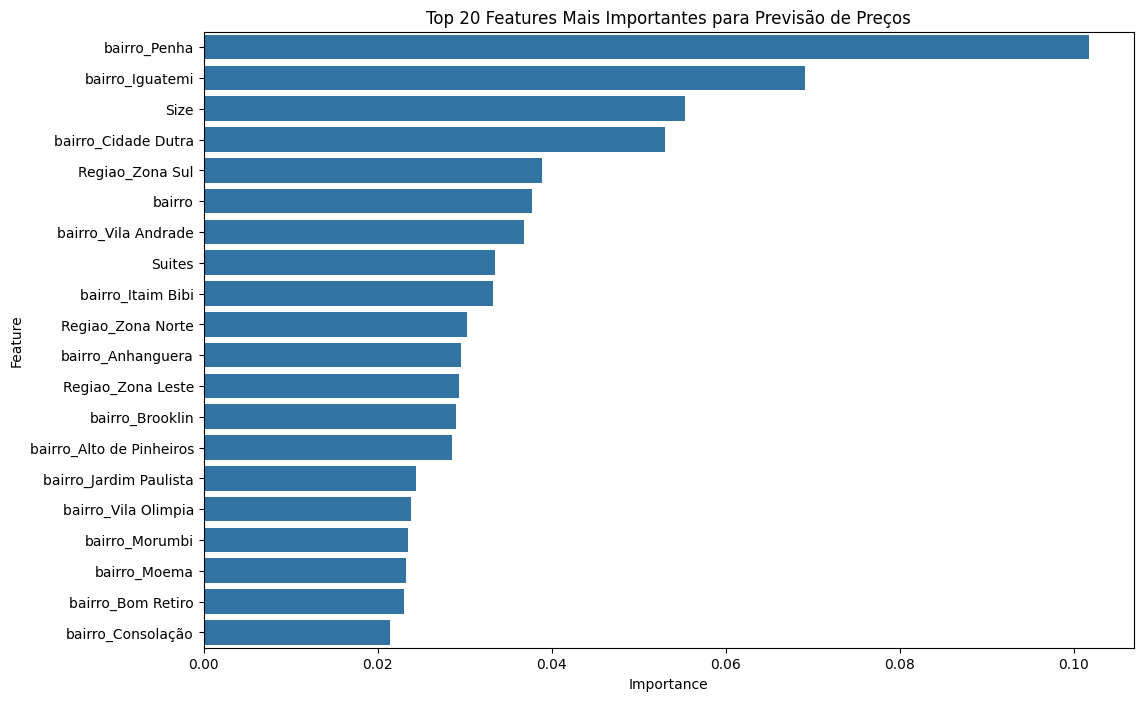

In [234]:
# Visualiza√ß√£o
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Features Mais Importantes para Previs√£o de Pre√ßos')
plt.show()

In [235]:
import joblib

# Salvar o modelo
joblib.dump(model, r'C:\Users\luuka\Downloads\modelo_precos_sp.pkl')

['C:\\Users\\luuka\\Downloads\\modelo_precos_sp.pkl']

In [236]:
import joblib
import pandas as pd

def prever_preco(Size, Rooms, Parking, bairro, Suites, Toilets, Regiao):
    """
    Fun√ß√£o para prever pre√ßos de im√≥veis com todos os par√¢metros necess√°rios
    
    Par√¢metros obrigat√≥rios:
    - Size: √Årea constru√≠da em m¬≤ (float)
    - Rooms: N√∫mero de quartos (int)
    - Parking: Vagas de garagem (int)
    - bairro: Nome do bairro (str)
    - Suites: N√∫mero de su√≠tes (int)
    - Toilets: N√∫mero de banheiros (int)
    
    Par√¢metro opcional:
    - Regiao: Regi√£o da cidade (str) - pode ser None
    """
    try:
        # Carregar modelo
        model = joblib.load(r'C:\Users\luuka\Downloads\modelo_precos_sp.pkl')
        
        # Criar DataFrame com todos os par√¢metros
        input_data = pd.DataFrame({
            'Size': [Size],
            'Rooms': [Rooms],
            'Parking': [Parking],
            'bairro': [bairro],
            'Suites': [Suites],
            'Toilets': [Toilets],
            'Regiao': [Regiao]
        })
        
        
        # Calcular m√©dia do bairro
        input_data['MEDIA_PRECO_DISTRITO'] = df[df['bairro'] == bairro]['preco_m2'].mean()
        
        # Fazer previs√£o
        return model.predict(input_data)[0]
    
    except Exception as e:
        print(f"Erro na previs√£o: {str(e)}")
        return None

In [237]:
prever_preco

<function __main__.prever_preco(Size, Rooms, Parking, bairro, Suites, Toilets, Regiao)>

In [238]:
prever_preco(59, 2, 1, 'Ipiranga', 1, 2, 'Zona Sul')

393336.66

In [ ]:
mapeamento_regioes = {
    # Zona Leste
    'Artur Alvim': 'Zona Leste',
    'Canga√≠ba': 'Zona Leste',
    'Carr√£o': 'Zona Leste',
    'Cidade L√≠der': 'Zona Leste',
    'Cidade Tiradentes': 'Zona Leste',
    'Ermelino Matarazzo': 'Zona Leste',
    'Itaim Paulista': 'Zona Leste',
    'Itaquera': 'Zona Leste',
    'Jardim Helena': 'Zona Leste',
    'Jos√© Bonif√°cio': 'Zona Leste',
    'Lajeado': 'Zona Leste',
    'Parque do Carmo': 'Zona Leste',
    'Ponte Rasa': 'Zona Leste',
    'S√£o Mateus': 'Zona Leste',
    'S√£o Miguel': 'Zona Leste',
    'S√£o Rafael': 'Zona Leste',
    'Vila Curu√ß√°': 'Zona Leste',
    'Vila Formosa': 'Zona Leste',
    'Aricanduva': 'Zona Leste',
    'Guaianazes': 'Zona Leste',
    'Penha': 'Zona Leste',
    'Tatuap√©': 'Zona Leste',
    'Vila Matilde': 'Zona Leste',
    'Mooca': 'Zona Leste',
    'Bel√©m': 'Zona Leste',
    '√Ågua Rasa': 'Zona Leste',
    'Sapopemba': 'Zona Leste',
    'S√£o Lucas': 'Zona Leste',
    'Vila Jacu√≠': 'Zona Leste',
    'Vila Prudente': 'Zona Leste',
    'Iguatemi': 'Zona Leste',
    
    # Zona Sul
    'Campo Belo': 'Zona Sul',
    'Campo Grande': 'Zona Sul',
    'Campo Limpo': 'Zona Sul',
    'Cap√£o Redondo': 'Zona Sul',
    'Cidade Ademar': 'Zona Sul',
    'Cidade Dutra': 'Zona Sul',
    'Graja√∫': 'Zona Sul',
    'Ipiranga': 'Zona Sul',
    'Itaim Bibi': 'Zona Sul',
    'Jabaquara': 'Zona Sul',
    'Jardim √Çngela': 'Zona Sul',
    'Jardim Paulista': 'Zona Sul',
    'Moema': 'Zona Sul',
    'Morumbi': 'Zona Sul',
    'Sacom√£': 'Zona Sul',
    'Santo Amaro': 'Zona Sul',
    'Sa√∫de': 'Zona Sul',
    'Socorro': 'Zona Sul',
    'Vila Andrade': 'Zona Sul',
    'Vila Mariana': 'Zona Sul',
    'Vila S√¥nia': 'Zona Sul',
    'Brooklin': 'Zona Sul',
    'Vila Olimpia': 'Zona Sul',
    'Pedreira': 'Zona Sul',
    'Cursino': 'Zona Sul',
    'Cambuci': 'Zona Sul',
    'Jardim S√£o Luis': 'Zona Sul',
    
    # Zona Oeste
    'Alto de Pinheiros': 'Zona Oeste',
    'Butant√£': 'Zona Oeste',
    'Jaguar√©': 'Zona Oeste',
    'Lapa': 'Zona Oeste',
    'Perdizes': 'Zona Oeste',
    'Pinheiros': 'Zona Oeste',
    'Vila Leopoldina': 'Zona Oeste',
    'Vila Madalena': 'Zona Oeste',
    'Raposo Tavares': 'Zona Oeste',
    'Rio Pequeno': 'Zona Oeste',
    'Pirituba': 'Zona Oeste',
    'Perus': 'Zona Oeste',
    'Anhanguera': 'Zona Oeste',
    'Jaragu√°': 'Zona Oeste',
    'S√£o Domingos': 'Zona Oeste',
    
    # Zona Norte
    'Casa Verde': 'Zona Norte',
    'Santana': 'Zona Norte',
    'Tucuruvi': 'Zona Norte',
    'Mandaqui': 'Zona Norte',
    'Trememb√©': 'Zona Norte',
    'Vila Guilherme': 'Zona Norte',
    'Vila Maria': 'Zona Norte',
    'Ja√ßan√£': 'Zona Norte',
    'Brasil√¢ndia': 'Zona Norte',
    'Freguesia do √ì': 'Zona Norte',
    'Lim√£o': 'Zona Norte',
    'Cachoeirinha': 'Zona Norte',
    'Medeiros': 'Zona Norte',
    
    # Centro
    'Barra Funda': 'Centro',
    'Bela Vista': 'Centro',
    'Bom Retiro': 'Centro',
    'Br√°s': 'Centro',
    'Consola√ß√£o': 'Centro',
    'Liberdade': 'Centro',
    'Rep√∫blica': 'Centro',
    'Santa Cec√≠lia': 'Centro',
    'S√©': 'Centro',
    'Pari': 'Centro'
}

def previsao_interativa():
    """Fun√ß√£o interativa que determina a regi√£o automaticamente pelo bairro"""
    
    print("\n=== PREVIS√ÉO DE PRE√áOS DE IM√ìVEIS EM S√ÉO PAULO ===")
    print("Por favor, informe os dados solicitados (digite 'sair' a qualquer momento para cancelar):\n")
    
    try:
        # Coletar dados do im√≥vel
        print("‚ñå DADOS DO IM√ìVEL ‚ñå")
        Size = input("‚Ä¢ √Årea constru√≠da (m¬≤): ")
        if Size.lower() == 'sair': return
        Size = float(Size)
        
        Rooms = input("‚Ä¢ N√∫mero de quartos: ")
        if Rooms.lower() == 'sair': return
        Rooms = int(Rooms)
        
        Suites = input("‚Ä¢ N√∫mero de su√≠tes: ")
        if Suites.lower() == 'sair': return
        Suites = int(Suites)
        
        Toilets = input("‚Ä¢ N√∫mero de banheiros: ")
        if Toilets.lower() == 'sair': return
        Toilets = int(Toilets)
        
        Parking = input("‚Ä¢ Vagas de garagem: ")
        if Parking.lower() == 'sair': return
        Parking = int(Parking)
        
        # Coletar localiza√ß√£o com tratamento especial
        print("\n‚ñå LOCALIZA√á√ÉO ‚ñå")
        while True:
            bairro = input("‚Ä¢ Bairro (ex: 'Pinheiros', 'Moema'): ").strip().title()
            if bairro.lower() == 'sair': return
            
            # Verificar se o bairro est√° no mapeamento
            Regiao = mapeamento_regioes.get(bairro, None)
            
            if Regiao is not None:
                break
            else:
                print(f"Bairro '{bairro}' n√£o encontrado. Por favor, digite novamente.")
                print("Dica: Digite apenas o nome do bairro (ex: 'Tatuap√©' em vez de 'Tatuap√©/S√£o Paulo')")
        
        print(f"\n‚ÑπÔ∏è Regi√£o determinada automaticamente: {Regiao}")
        
        # Fazer previs√£o
        preco = prever_preco(
            Size=Size,
            Rooms=Rooms,
            Parking=Parking,
            bairro=bairro,
            Suites=Suites,
            Toilets=Toilets,
            Regiao=Regiao
        )
        
        # Mostrar resultado completo
        if preco is not None:
            print("\n" + "="*60)
            print("üìã RESUMO DOS DADOS INFORMADOS")
            print("-"*60)
            print(f"‚ñ™ √Årea constru√≠da: {Size} m¬≤")
            print(f"‚ñ™ Quartos: {Rooms} (Su√≠tes: {Suites})")
            print(f"‚ñ™ Banheiros: {Toilets}")
            print(f"‚ñ™ Vagas: {Parking}")
            print(f"‚ñ™ Localiza√ß√£o: {bairro} - {Regiao}")
            
            print("\nüí≤ RESULTADO DA PREVIS√ÉO")
            print("-"*60)
            print(f"Valor estimado: R$ {preco:,.2f}")
            print(f"Faixa sugerida: R$ {preco*0.85:,.2f} a R$ {preco*1.15:,.2f}")
            print("="*60)
        else:
            print("\nN√£o foi poss√≠vel calcular a previs√£o.")
            
    except ValueError:
        print("\nErro: Por favor, digite valores num√©ricos nos campos solicitados.")
    except Exception as e:
        print(f"\nOcorreu um erro: {str(e)}")

# Instru√ß√µes para uso:
print("\nINSTRU√á√ïES:")
print("1. Digite apenas o nome do bairro (sem '/S√£o Paulo')")
print("2. O sistema identificar√° automaticamente a regi√£o")
print("3. Digite 'sair' a qualquer momento para cancelar\n")

# Exemplo de uso:
previsao_interativa()


INSTRU√á√ïES:
1. Digite apenas o nome do bairro (sem '/S√£o Paulo')
2. O sistema identificar√° automaticamente a regi√£o
3. Digite 'sair' a qualquer momento para cancelar


=== PREVIS√ÉO DE PRE√áOS DE IM√ìVEIS EM S√ÉO PAULO ===
Por favor, informe os dados solicitados (digite 'sair' a qualquer momento para cancelar):

‚ñå DADOS DO IM√ìVEL ‚ñå

‚ñå LOCALIZA√á√ÉO ‚ñå

‚ÑπÔ∏è Regi√£o determinada automaticamente: Zona Oeste

üìã RESUMO DOS DADOS INFORMADOS
------------------------------------------------------------
‚ñ™ √Årea constru√≠da: 50.0 m¬≤
‚ñ™ Quartos: 2 (Su√≠tes: 1)
‚ñ™ Banheiros: 2
‚ñ™ Vagas: 1
‚ñ™ Localiza√ß√£o: Pinheiros - Zona Oeste

üí≤ RESULTADO DA PREVIS√ÉO
------------------------------------------------------------
Valor estimado: R$ 607,956.56
Faixa sugerida: R$ 516,763.08 a R$ 699,150.05


In [253]:
def previsao_interativa():
    """Fun√ß√£o interativa que determina a regi√£o automaticamente pelo bairro"""
    
    print("\n=== PREVIS√ÉO DE PRE√áOS DE IM√ìVEIS EM S√ÉO PAULO ===")
    print("Por favor, informe os dados solicitados (digite 'sair' a qualquer momento para cancelar):\n")
    
    try:
        # Coletar dados do im√≥vel
        print("‚ñå DADOS DO IM√ìVEL ‚ñå")
        Size = input("‚Ä¢ √Årea constru√≠da (m¬≤): ")
        if Size.lower() == 'sair': return
        Size = float(Size)
        if Size <= 10:
            print("‚ùå Valor inv√°lido. A √°rea m√≠nima deve ser maior que 10m¬≤. Digite novamente.")
            return
        Rooms = input("‚Ä¢ N√∫mero de quartos: ")
        if Rooms.lower() == 'sair': return
        Rooms = int(Rooms)
        if Rooms < 1:
            print("‚ùå Valor inv√°lido. O valor m√≠nimo √© 1.")
            return
        Suites = input("‚Ä¢ N√∫mero de su√≠tes: ")
        if Suites.lower() == 'sair': return
        Suites = int(Suites)
        
        Toilets = input("‚Ä¢ N√∫mero de banheiros: ")
        if Toilets.lower() == 'sair': return
        Toilets = int(Toilets)
        if Toilets < 1:
            print("‚ùå Valor inv√°lido. O valor m√≠nimo √© 1.")
            return
        Parking = input("‚Ä¢ Vagas de garagem: ")
        if Parking.lower() == 'sair': return
        Parking = int(Parking)
        
        # Coletar localiza√ß√£o com tratamento especial
        print("\n‚ñå LOCALIZA√á√ÉO ‚ñå")
        while True:
            bairro = input("‚Ä¢ Bairro (ex: 'Pinheiros', 'Moema'): ").strip().title()
            if bairro.lower() == 'sair': return
            
            # Verificar se o bairro est√° no mapeamento
            Regiao = mapeamento_regioes.get(bairro, None)
            
            if Regiao is not None:
                break
            else:
                print(f"Bairro '{bairro}' n√£o encontrado. Por favor, digite novamente.")
                print("Dica: Digite apenas o nome do bairro (ex: 'Tatuap√©' em vez de 'Tatuap√©/S√£o Paulo')")
        
        print(f"\n‚ÑπÔ∏è Regi√£o determinada automaticamente: {Regiao}")
        
        # Fazer previs√£o
        preco = prever_preco(
            Size=Size,
            Rooms=Rooms,
            Parking=Parking,
            bairro=bairro,
            Suites=Suites,
            Toilets=Toilets,
            Regiao=Regiao
        )
        
        # Mostrar resultado completo
        if preco is not None:
            print("\n" + "="*60)
            print("üìã RESUMO DOS DADOS INFORMADOS")
            print("-"*60)
            print(f"‚ñ™ √Årea constru√≠da: {Size} m¬≤")
            print(f"‚ñ™ Quartos: {Rooms} (Su√≠tes: {Suites})")
            print(f"‚ñ™ Banheiros: {Toilets}")
            print(f"‚ñ™ Vagas: {Parking}")
            print(f"‚ñ™ Localiza√ß√£o: {bairro} - {Regiao}")
            
            print("\nüí≤ RESULTADO DA PREVIS√ÉO")
            print("-"*60)
            print(f"Valor estimado: R$ {preco:,.2f}")
            print(f"Faixa sugerida: R$ {preco*0.85:,.2f} a R$ {preco*1.15:,.2f}")
            print("="*60)
        else:
            print("\nN√£o foi poss√≠vel calcular a previs√£o.")
            
    except ValueError:
        print("\nErro: Por favor, digite valores num√©ricos nos campos solicitados.")
    except Exception as e:
        print(f"\nOcorreu um erro: {str(e)}")

# Instru√ß√µes para uso:
print("\nINSTRU√á√ïES:")
print("1. Digite apenas o nome do bairro (sem '/S√£o Paulo')")
print("2. O sistema identificar√° automaticamente a regi√£o")
print("3. Digite 'sair' a qualquer momento para cancelar\n")

# Exemplo de uso:
previsao_interativa()


INSTRU√á√ïES:
1. Digite apenas o nome do bairro (sem '/S√£o Paulo')
2. O sistema identificar√° automaticamente a regi√£o
3. Digite 'sair' a qualquer momento para cancelar


=== PREVIS√ÉO DE PRE√áOS DE IM√ìVEIS EM S√ÉO PAULO ===
Por favor, informe os dados solicitados (digite 'sair' a qualquer momento para cancelar):

‚ñå DADOS DO IM√ìVEL ‚ñå

‚ñå LOCALIZA√á√ÉO ‚ñå

‚ÑπÔ∏è Regi√£o determinada automaticamente: Zona Oeste

üìã RESUMO DOS DADOS INFORMADOS
------------------------------------------------------------
‚ñ™ √Årea constru√≠da: 70.0 m¬≤
‚ñ™ Quartos: 2 (Su√≠tes: 1)
‚ñ™ Banheiros: 2
‚ñ™ Vagas: 1
‚ñ™ Localiza√ß√£o: Perdizes - Zona Oeste

üí≤ RESULTADO DA PREVIS√ÉO
------------------------------------------------------------
Valor estimado: R$ 673,885.31
Faixa sugerida: R$ 572,802.52 a R$ 774,968.11
